In [24]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

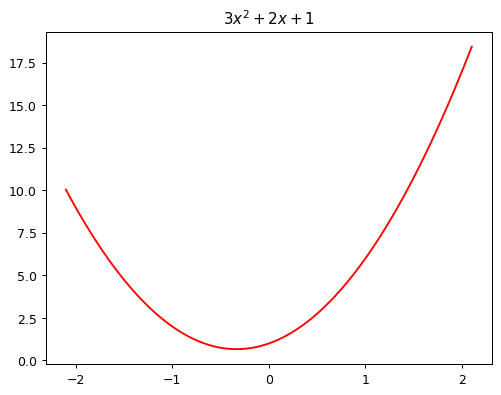

In [25]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

In [26]:
def quad(a, b, c, x): return a*x**2 + b*x + c


In [27]:
quad(3,2,1,1.5)

10.75

In [28]:
from functools import partial
def mk_quad(a,b,c): return partial(quad, a,b,c)

In [29]:
f = mk_quad(3,2,1)
f(1.5)

10.75

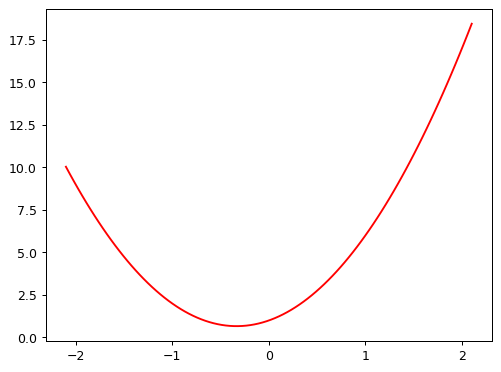

In [30]:
plot_function(f)

In [31]:
from numpy.random import normal,seed,uniform
np.random.seed(42)
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

note - in the lecture, the next cell was run twice. so it's the seed 42, plus one run of the random generator

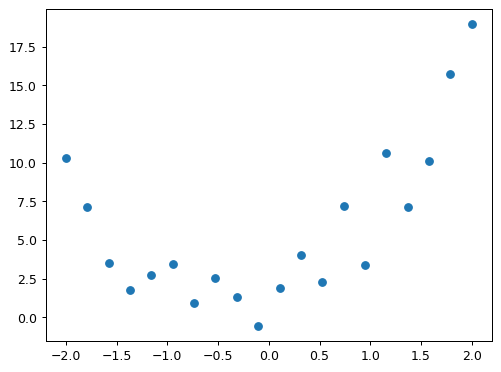

In [32]:
x = torch.linspace(-2, 2, steps=20)[:,None]
np.random.seed(42)
y = add_noise(f(x), 0.3, 1.5)
y = add_noise(f(x), 0.3, 1.5) # run it twice to reproduce results
plt.scatter(x,y)

In [33]:
from ipywidgets import interact
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a,b,c):
    plt.scatter(x, y)
    plot_function(mk_quad(a,b,c), ylim=(-3,12))

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

In [34]:
# Need something we can measure to tell us how the model is doing - a loss function
# how about mean squared error

def mse(preds, acts): return ((preds-acts)**2).mean()

In [35]:
@interact(a=1.5, b=1.5, c=1.5)
def plot_quad(a,b,c):
    f = mk_quad(a,b,c)
    plt.scatter(x, y)
    loss=mse(f(x), y)
    plot_function(f, ylim=(-3,12), title=f"MSE: {loss:.2f}")

interactive(children=(FloatSlider(value=1.5, description='a', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

So we have a way to manually play with some numbers to optimize the loss. Let's automate it.

In [36]:
def quad_mse(params):
    f = mk_quad(*params)
    return mse(f(x), y)

In [37]:
quad_mse([1.5, 1.5, 1.5])

tensor(11.4648, dtype=torch.float64)

In [38]:
# rank 1 tensor
abc = torch.tensor([1.5, 1.5, 1.5])
abc.requires_grad_() # Flag it, calculate gradients

tensor([1.5000, 1.5000, 1.5000], requires_grad=True)

In [39]:
loss = quad_mse(abc)
loss

tensor(11.4648, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [40]:
loss.backward()
abc.grad

tensor([-10.9887,  -2.1225,  -4.0015])

Note for myself - I don't quite understand how these gradients are calcualted.

Specifically, the combination of `requires_grad_()` and `backward()`

There's a bit of magic too, with the `mse()` operating using tensors (seems like it has good arithmetic operator support)

In [41]:
with torch.no_grad(): # standard inner thing, telling it to temporarily not calculated the gradients.... whatever
    abc -= abc.grad*0.01
    loss = quad_mse(abc)

print(f'loss={loss:.2f}')

loss=10.11


In [42]:
for i in range(5):
    loss = quad_mse(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad*0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=10.11
step=1; loss=7.88
step=2; loss=5.53
step=3; loss=3.86
step=4; loss=3.42


In [43]:
abc

tensor([3.1960, 1.9035, 2.0870], requires_grad=True)

oh my duck. it's gradient descent
and it's nearly the entire foundation for NNs

now we need "one more thing"

In [44]:
def rectified_linear(m,b,x):
    y = m*x+b
    return torch.clip(y, 0.)

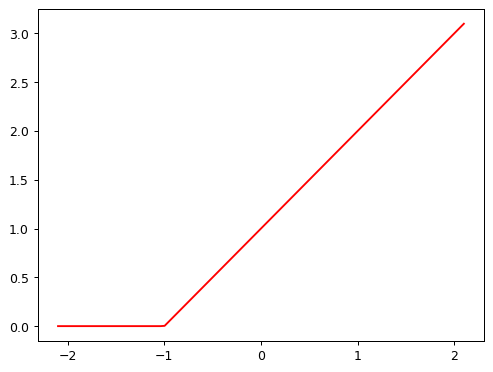

In [45]:
plot_function(partial(rectified_linear, 1, 1))

In [46]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m, b), ylim=(-1, 4))

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

still not so interesting

In [47]:
def double_relu(m1, b1, m2, b2, x):
    return rectified_linear(m1, b1, x) + rectified_linear(m2, b2, x)

In [49]:
@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1, b1, m2, b2), ylim=(-1, 4))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

ok yeah, we can imagine a function which is the sum of a whole bunch of (n) RELUs, total of `2n` coefficients

hand waving, but it works over more dimensions

and that's it!

- ReLUs getting added together
- gradient descent optimized parameters
- samples of inputs and outputs that you want

so maybe we wants lots of ReLUs
like, each pixel gets multiplied by something, and then add them all together (so just `sum(m*x)`)

that's matrix multiplication!

(well, not the replace negative with zeroes part, or the `+b` part)

The `+b` part is solved by adding a new column in the input with a constant 1, and so you actually have `n+1` coeffecients.

`b = m_nplus1 * x_nplus1`
`m1*x1 + m2*x2 + .... + b`

(now, abbreviating the work in the excel model)

1. The input is a bunch of rows of normalized columns + the `constant(1)` column to get our `b` value
1. Start with random values for m
1. Calculate the loss (`pred-actual`) for each element in the input dataset
1. The total loss is the `mse` of all of those losses

even after solving through gradient descent, it's possible to get predictions that are negative, as opposed to [0,1]

so let's call the above

`pred(x) = m(x) + b`, or more simple `pred(x) = m(x)`

now, we'll to

`pred(x) = relu(m1(x)) + relu(m2(x))`

it's easy to express the above as a matrix multiplication

training set has `N` elements with `M` fields, so we'll call it an `NxM` matrix

we'll need coefficients in the shape of `MxK`, where K is the number of ReLU units we'll add up

So we multiply to get a `NxK` output, which we then ReLU each cell, and then sum up the rows to get `N` predictions. From this, we calcaulate `N` losses, and one total loss via `mse()`

the one thing here that is not covered is that the network doesn't have any layers.